In [1]:
# Class dependencies
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import pickle


# Other analysis libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from model_dallin import OrigamiNetwork

# Square

In [2]:
# layer = lambda D, n: D - 2 * np.outer((D@n)/np.dot(n, n), n)
def layer(D, n):
    scales = (D@n)/np.dot(n, n)
    mask = scales > 1
    projected = 2 * np.outer(scales, n)
    adjustment = 2*n - projected
    return D + mask[:,np.newaxis] * adjustment

In [3]:
fv1 = .5*np.array([1,1])
fv2 = np.array([-1,1])
fv3 = np.array([-.85,0])
size = 20

# make a meshgrid of x and y values
x1 = np.linspace(-2,2,size)
x2 = np.linspace(-2,2,size)
X1,X2 = np.meshgrid(x1,x2)

# reshape the meshgrid into a 2D array and concatenate them
X1 = X1.reshape(-1,1)
X2 = X2.reshape(-1,1)
pairs = np.concatenate((X1,X2),axis=1)
cut1 = layer(pairs, fv1)
cut2 = layer(cut1, fv2)
cut = layer(cut2, fv3)
Y = cut[:,1] > .6

In [4]:
test = OrigamiNetwork(layers=5, max_iter=1000, learning_rate=0.01, optimizer="grad", reg=0)
fold_history = test.fit(pairs, Y)
out = test.forward_pass(pairs)

Training Progress: 100%|██████████| 1000/1000 [00:01<00:00, 784.14it/s]


In [5]:
# test.fold_vectors = np.array([[0, -1],
#                              [1.5, 0],
#                              [0, -0.2], 
#                              [1, 0],
#                              [-0.5, 0],
#                              [0.5, 0.5]])
# test.layers = len(test.fold_vectors)

Loss Layer 0: 100%|██████████| 2500/2500 [00:02<00:00, 867.46it/s] 


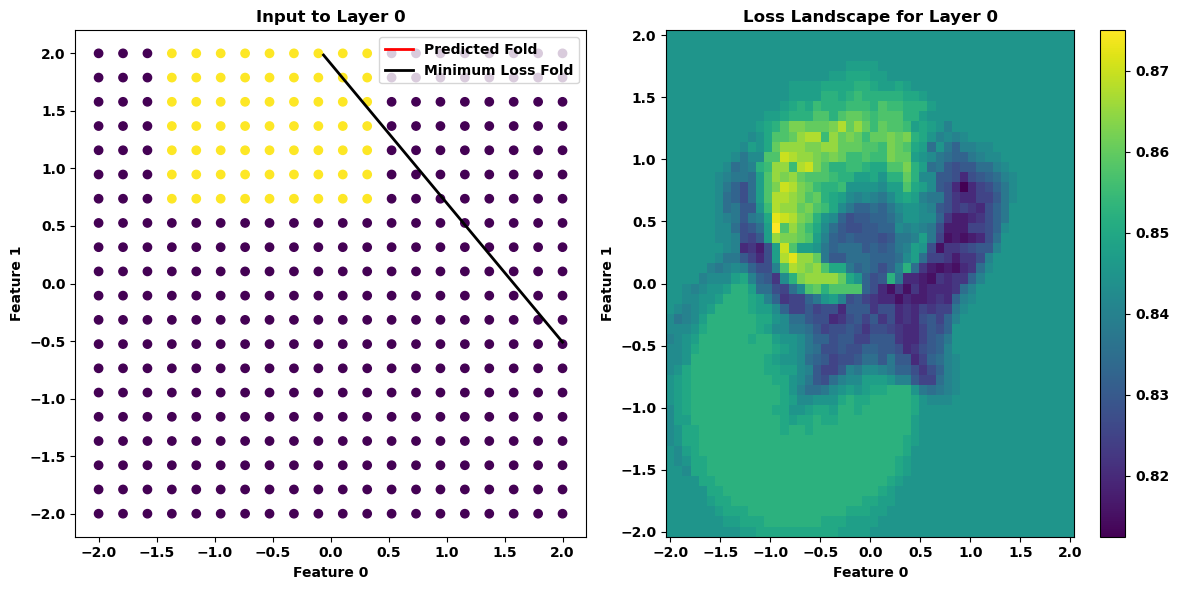

Loss Layer 1: 100%|██████████| 2500/2500 [00:02<00:00, 876.26it/s] 


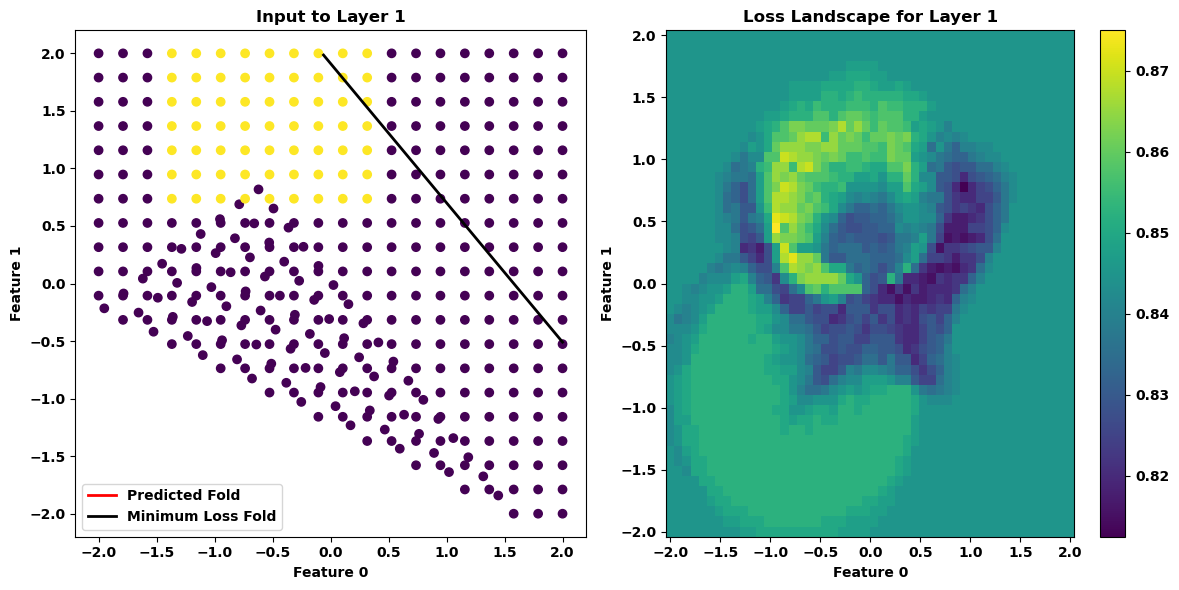

Loss Layer 2: 100%|██████████| 2500/2500 [00:03<00:00, 789.46it/s]


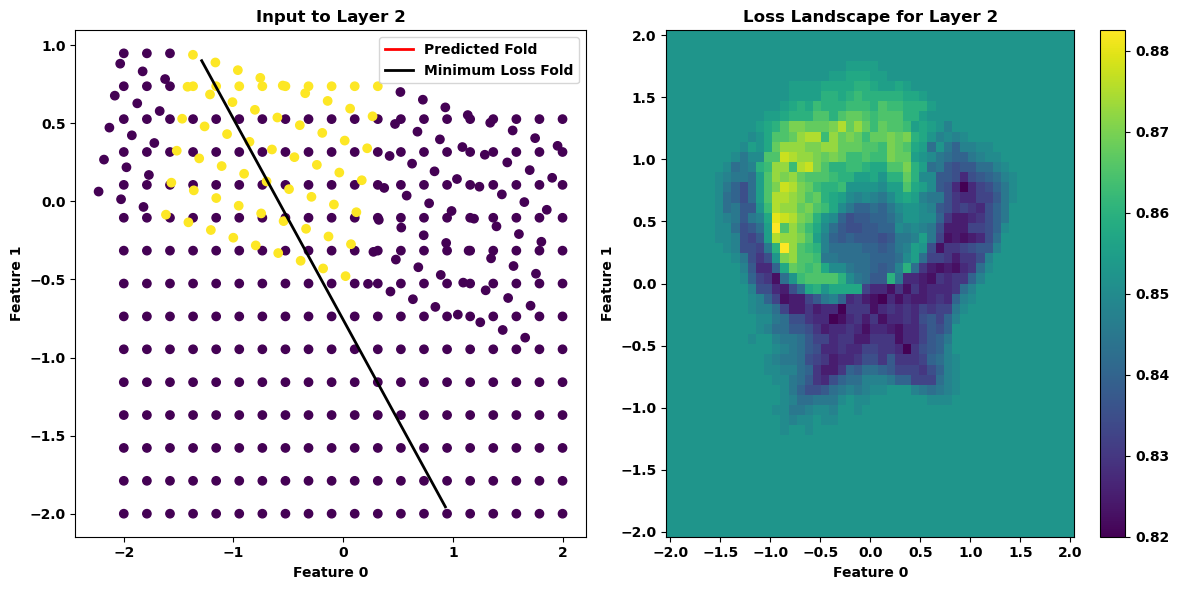

Loss Layer 3: 100%|██████████| 2500/2500 [00:02<00:00, 987.29it/s] 


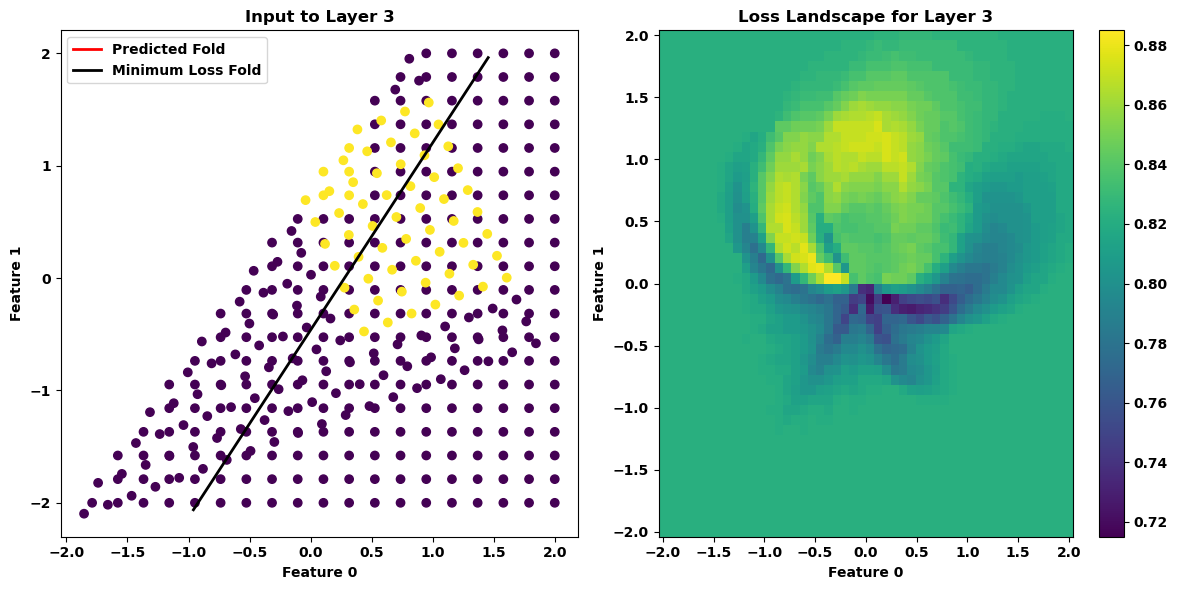

Loss Layer 4: 100%|██████████| 2500/2500 [00:02<00:00, 981.41it/s] 


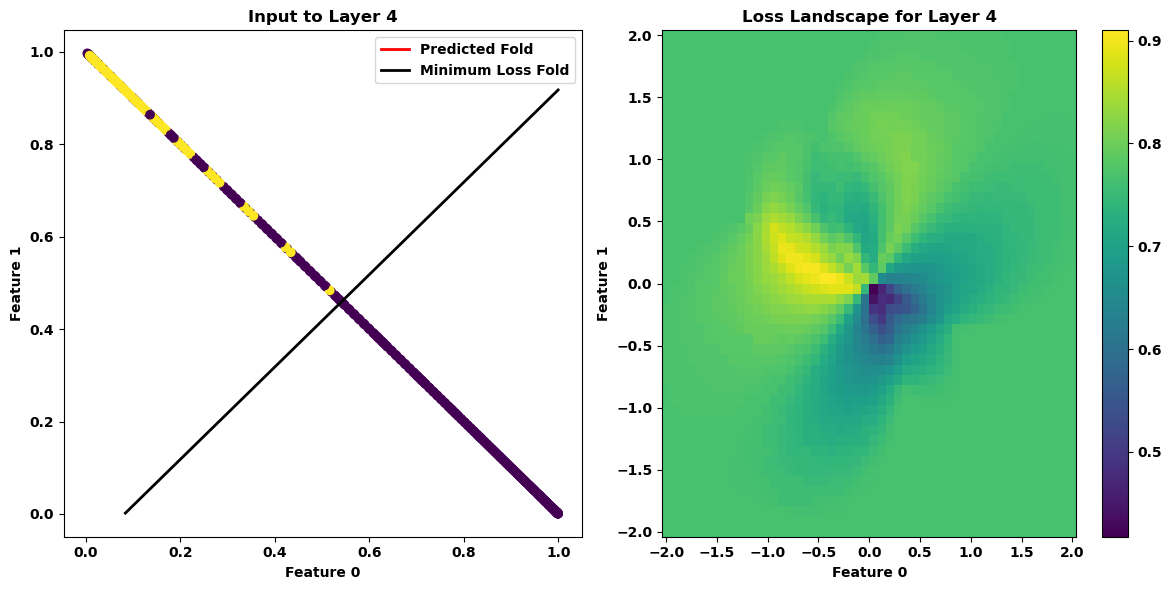

([0.8125, 0.8125, 0.82, 0.715, 0.4175],
 [array([0.93877551, 0.7755102 ]),
  array([0.93877551, 0.7755102 ]),
  array([-0.36734694, -0.28571429]),
  array([ 0.20408163, -0.12244898]),
  array([ 0.04081633, -0.04081633])])

In [6]:
test.loss_landscape(loss_layers=None, create_plot=True, density=50, verbose=1)

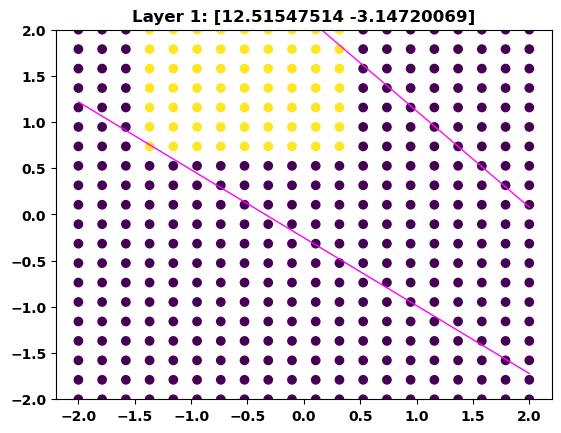

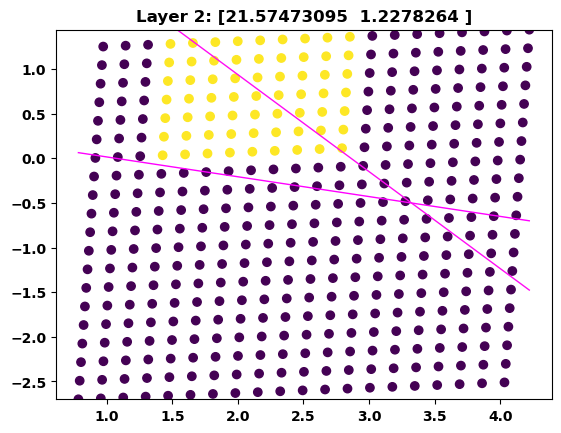

KeyboardInterrupt: 

In [6]:
n_colors = 20
cmap = plt.get_cmap('spring')
colors = [cmap(i / n_colors) for i in range(n_colors)]

def draw_fold(hyperplane, color):
    if hyperplane[1] == 0:
        # draw a vertical line
        plt.plot([hyperplane[0], hyperplane[0]], [np.min(outy), np.max(outy)], color=color, lw=1)
    elif hyperplane[0] == 0:
        # draw a horizontal line
        plt.plot([np.min(outx), np.max(outx)], [hyperplane[1], hyperplane[1]], color=color, lw=1)
    else:
        a, b = hyperplane
        slope = -a / b
        intercept = b - slope * a
        plane_range = slope * plane_domain + intercept
        plt.plot(plane_domain, plane_range, color=color, lw=1)

out = test.forward_pass(pairs)
for i in range(len(out)-1):
    outx = out[i][:,0]
    outy = out[i][:,1]
    
    if i < len(test.fold_vectors):
        hyperplane = test.fold_vectors[i]
        plane_domain = np.linspace(np.min(outx), np.max(outx), 100)
        for j in range(len(fold_history)):
            if j % 50 == 0:
                draw_fold(fold_history[j][i], color=colors[j//50])

    plt.scatter(outx, outy, c = Y)
    plt.ylim(np.min(outy), np.max(outy))
    plt.title(f"Layer {i+1}: {hyperplane}")
    plt.show()

# test.back_propagation(np.arange(10))
# print(forward)
# print([(i, test.fold_vectors[i-1]) for i in range(test.layers, 0, -1)])
# [test.derivative_fold(forward[i], test.fold_vectors[i-1]) for i in range(test.layers, 0, -1)]

# Simple 3x3

In [5]:
np.array([[1,2,3],[4,5,6],[7,8,9]])[np.array([0,2,2])]

array([[1, 2, 3],
       [7, 8, 9],
       [7, 8, 9]])

In [6]:
# Test case
Z = np.array([[1, 2, 3], [4, 5, 6]])
n = np.array([1, -1/2, 1])
width = len(n)

def derivative_fold(Z, n):
    # Get the scaled inner product, mask, and make the identity stack
    n_normal = n / np.dot(n,n)
    scales = Z@n_normal
    mask = scales > 1
    identity_stack = np.stack([np.eye(width) for _ in range(len(Z))])
    
    # Calculate the first component and a helper term
    first_component = (1 - scales[:,np.newaxis, np.newaxis]) * identity_stack
    helper = 2*Z @ n_normal
    
    # Calculate the outer product of n and helper, then subtract the input
    outer_product = np.outer(helper, n_normal) - Z
    second_component = np.einsum('ij,k->ikj', outer_product, n_normal)
    
    # Return the derivative
    return 2 * mask[:,np.newaxis, np.newaxis] * (first_component + second_component)


result = derivative_fold(Z, n)
print(result)


[[[-0.50205761 -2.30452675 -1.61316872]
  [-0.08230453  0.48559671  0.80658436]
  [ 0.16460905 -2.30452675 -2.27983539]]

 [[-5.58847737 -5.76131687 -2.69958848]
  [ 0.46090535 -1.78600823  1.34979424]
  [-0.9218107  -5.76131687 -7.36625514]]]


In [7]:
x = np.array([1,2,3])
n = np.array([1,-1/2,1])
n_normal = n / np.dot(n,n)

first_comp = np.eye(3)*(1 - x@n_normal)

helper = 2*(x@n_normal)
inner = helper * n_normal - x
second_comp = np.outer(n_normal, inner)
print(2*(first_comp + second_comp))

[[-0.50205761 -2.30452675 -1.61316872]
 [-0.08230453  0.48559671  0.80658436]
 [ 0.16460905 -2.30452675 -2.27983539]]


# Circle

Training Progress: 100%|██████████| 1000/1000 [00:01<00:00, 841.96it/s]


[[ 3.29346389e+00  5.21821931e+00]
 [ 2.01584418e-01 -1.99097880e+00]
 [-1.02519930e-03  1.58187563e+00]
 [-7.97259691e-01 -2.60949379e-01]]


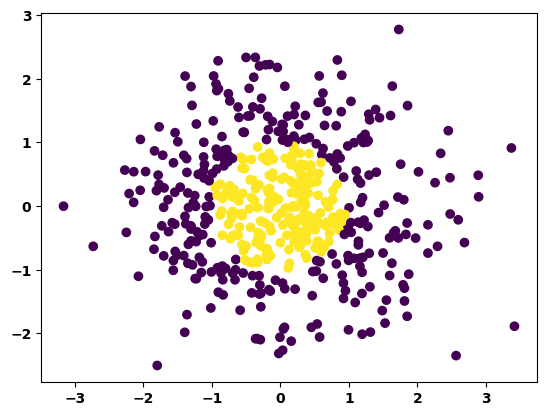

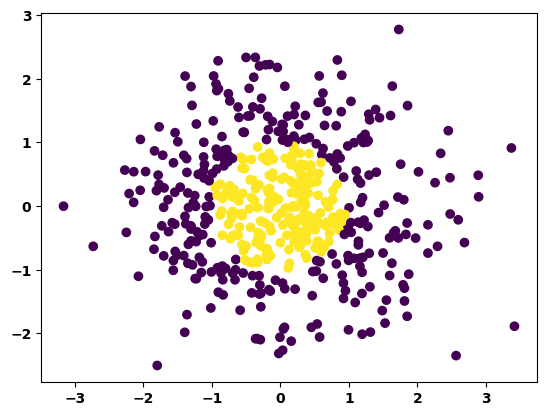

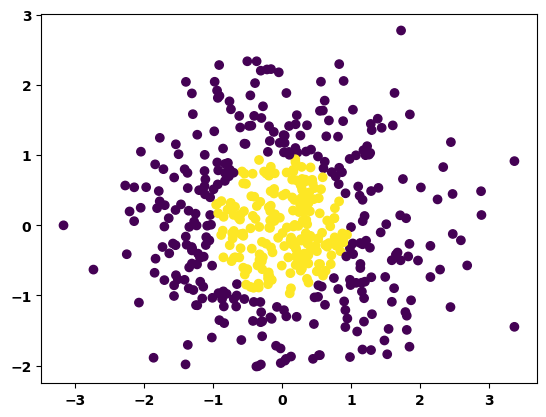

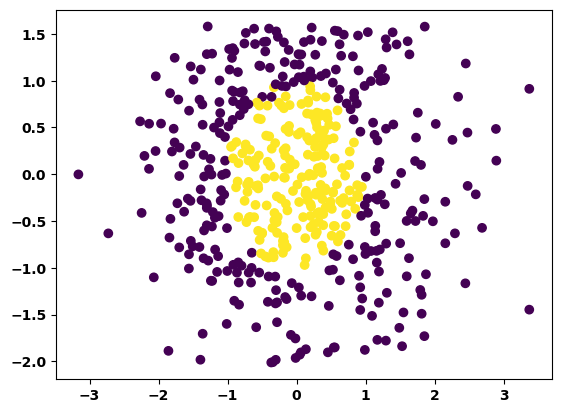

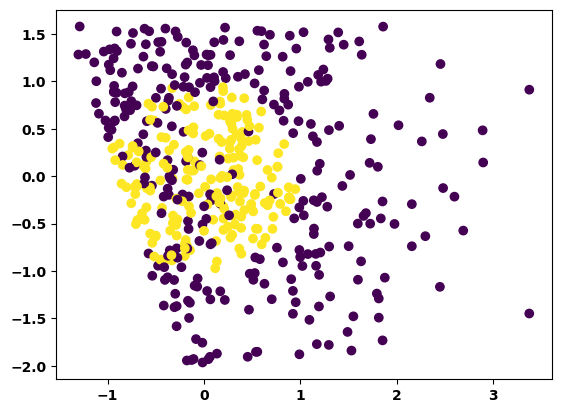

In [2]:
# Set up the model
layers = 4
width = 2
model = OrigamiNetwork(layers=layers, max_iter=1000, learning_rate=0.001)

# Create some dummy data
X = np.random.randn(500, width)
y = np.linalg.norm(X, axis=1) < 1

# # plot the data
# plt.scatter(X[:,0], X[:,1], c=y)
# plt.show()

# Set model parameters
model.fit(X, y)
print(model.fold_vectors)


out = model.forward_pass(X)
for i in range(len(out)-1):
    plt.scatter(out[i][:,0],out[i][:,1], c = y)
    plt.show()
    

In [3]:
y_hat = model.predict(X)

from sklearn.metrics import accuracy_score
print(accuracy_score(y, y_hat))

0.584


# Digits

In [10]:
# import small digits dataset
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
y = digits.target

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# set up the model
model = OrigamiNetwork(layers=3, max_iter=100, learning_rate=0.001)
model.fit(X_train, y_train)

# get the predictions
y_hat = model.predict(X_test)
print(accuracy_score(y_test, y_hat))

Training Progress: 100%|██████████| 100/100 [00:53<00:00,  1.86it/s]

0.8666666666666667


# OMSCS AI Challenge Question 2

In [15]:
def word_score(input, target):
    input = input.lower()
    target = target.lower()
    score = 0
    for i in range(len(input)):
        if input[i] == target[i]:
            score += 2
        elif input[i] in target:
            score += 1
    return score

target = 'sight'
inputs = [['state', 'scout', 'pilot', 'ghost'],
          ['spark', 'stark', 'stilt', 'stair'],
          ['might', 'tight', 'light', 'sight'],
          ['float', 'stoat', 'stilt', 'sight']]

for sequence in inputs:
    for word in sequence:
        print(word, word_score(word, target), end=' -> ')
    print()

state 4 -> scout 4 -> pilot 4 -> ghost 5 -> 
spark 2 -> stark 3 -> stilt 6 -> stair 4 -> 
might 8 -> tight 9 -> light 8 -> sight 10 -> 
float 2 -> stoat 5 -> stilt 6 -> sight 10 -> 


In [16]:
inputs = [['dflkz', 'skgkt', 'xetxt', 'fnyns', 'eihgd'],
          ['ypenb', 'ecbez', 'hqmnm', 'tskzh', 'sembt'],
          ['btpig', 'riuvq', 'fvght', 'sgprt', 'dujht']]

target = 'sight'
for sequence in inputs:
    for word in sequence:
        print(word, word_score(word, target), end=' - ')
    print()

dflkz 0 - skgkt 6 - xetxt 3 - fnyns 1 - eihgd 4 - 
ypenb 0 - ecbez 0 - hqmnm 1 - tskzh 3 - sembt 4 - 
btpig 3 - riuvq 2 - fvght 6 - sgprt 5 - dujht 4 - 


In [34]:
def sim_anneal(problem, schedule, q, target):
    curr = problem[0]
    t = 1
    while t < len(problem):
        T = schedule(t)
        if T == 0:
            return curr
        next = problem[t]
        dE = word_score(next, target) - word_score(curr, target)
        p = np.exp(dE/T)
        if dE > 0:
            curr = next
        else:
            if q[t-1] <= p:
                curr = next
        print(t, q[t-1], min(round(p, 3), 1000), dE, next, curr, sep="\t")
        t += 1
    return curr

schedule = lambda t: 3/t
target = 'sight'
problem = ['hello', 'hails', 'sails', 'pills', 'spilt', 'still', 'spill', 'tight', 'light', 'sight']
q = [0.06, 0.31, 0.07, 0.08, 0.29, 0.02, 0.17, 0.07]
print("T", "q<", "Accept", "dE", "next", "curr", sep="\t")
print(sim_anneal(problem, schedule, q, target))

T	q<	Accept	dE	next	curr
1	0.06	1.948	2	hails	hails
2	0.31	1.948	1	sails	sails
3	0.07	0.368	-1	pills	pills
4	0.08	14.392	2	spilt	spilt
5	0.29	0.189	-1	still	spilt
6	0.02	0.018	-2	spill	spilt
7	0.17	1000	4	tight	tight
8	0.07	0.069	-1	light	tight


IndexError: list index out of range